### Table of Contents

1. [Getting Started](#Getting-Started)
  - [File descriptions](#File-descriptions)
2. [Background of the problem domain](#Background)
3. [Objective](#Objective)
4. [Datasets](#Datasets)
  - [About authors](#About-authors)
  - [Import libraries](#Import-libraries)
  - [Load datasets](#Load-datasets)
5. [Data exploration](#Data-exploration)
  - [Data fields](#Data fields)
  - [Quick statistics by grouping authors](#Quick-statistics-by-grouping-authors)
  - [Data distribution by each author](#Data-distribution-by-each-author)
  - [Distribution of semantics](#Distribution-of-semantics)
  - [Wordcloud](#Wordcloud)
6. [Data Preprocessing](#Data-Preprocessing)
  - [Binarizing target variable](#Binarizing-target-variable)
  - [Scrubbing of data](#Scrubbing-of-data)
7. [Shuffle and split data](#Shuffle-and-split-data)
8. [Word vectors](#Word-vectors)
9. [Evaluating model performance](#Evaluating-model-performance)
  - [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
  - [Logistic Regression](#Logistic-Regression)
  - [SVM](#SVM)
  - [Stochastic Gradient Descent Classifier](#Stochastic-Gradient-Descent-Classifier)
  - [XGBoost](#XGBoost)
  - [Model performance conclusion](#Model-performance-conclusion)
10. [Parameter tuning using GridSearchCV](#Parameter-tuning)
11. [Model training](#Model-training)
  - [Fit and predict the data]()
  - [Accuracy score](#Accuracy-score)
  - [Classification report](#Classification-report)
  - [ROC and AUC curves](#ROC-and-AUC-curves)
12. [Predict unexplored data](#Predict-unexplored-data)
  - [Predict](#Predict)
  - [Reflect author names](#Reflect-author-names)
13. [Conclusion](#Conclusion)
  - [Compare heatmaps from the prediction](#Compare-heatmaps-from-the-prediction)
  - [Compare Wordclouds from the prediction](#Compare-Wordclouds-from-the-prediction)

### Getting Started

The dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

##### Courtesy
https://www.kaggle.com/c/spooky-author-identification

##### File descriptions
`train.csv` - the training set

`test.csv` - the test set

`sample_submission.csv` - a sample submission file in the correct format

### Background

Since ancient days, discoveries, patents, analyses were and are often documented. It does not matter how they are documented.

They can be documented either in the form of wall paintings or wall embedded drawings or any sort of scripts.

Older documents are often referred to continue the research even now in every fields like literature, experiments, myths, etc.

However, it is necessary for the seeker or organisation that the authenticity of these documents are met. Still, there could be lots of anonymous and non-classified documents exists. 

So, how were these documents verified? In the ancient days, these were all manually verified. There are different patterns like style of writing, language of communication, etc. of understand from where these documents came in and potentially by whom. Also, do we have any similar documents identified earlier?

This is broadly known as Stylometry. Stylometry deals with the study of linguistic style and is widely adopted across academic, literary, music and fine arts. Also, known as authorship attribution.

Also, now-a-days, the anonymous nature of online-message distribution makes identity tracing a critical problem in our society where everything is online.

### Objective

Scan through the test documents and identify the potential author of each document.

### Datasets

Authorship attribution is indeed a huge field and is applicable across multiple domains.

This holds it application everywhere like forensics, mythologies, online messages, ancient belongings, etc.

For now, we shall limit our practive with the minimum dataset. The attached dataset holds for only three authors and they are:
- Edgar Allan Poe [EAP]
- Howard Phillips Lovecraft [HWS]
- Mary Wollstonecraft Shelley [MWS]

##### About authors

_Edgar Allan Poe_ was an American writer, editor, and literary critic. He is best known for his poetry and short stories, particularly his tales of mystery and the macabre.

_Howard Phillips Lovecraft_ was an American writer who achieved posthumous fame through his influential works of horror fiction.

_Mary Wollstonecraft Shelley_ was an English novelist, short story writer, dramatist, essayist, biographer, and travel writer, best known for her Gothic novel Frankenstein: or, The Modern Prometheus.

##### Import libraries

In [321]:
# !pip install wordcloud
# !pip install nltk

In [217]:
# Load libraries #

import csv
import json

import numpy
import pandas
from time import time

from matplotlib import pyplot
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

##### Load datasets

In [354]:
# Load all data #

authored_contents = pandas.read_csv("./author detection datasets/train.csv")

unauthored_contents = pandas.read_csv("./author detection datasets/test.csv")

In [355]:
authored_contents.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [356]:
unauthored_contents.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [221]:
authored_contents.shape

(19579, 3)

### Data Exploration

##### Data fields

`id` - a unique identifier for each sentence

`text` - some text written by one of the authors and is our feature.

`author` - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley). Hence, this is our target variable.

##### Quick statistics by grouping authors

In [223]:
training_records = len(authored_contents)

author_eap, author_mws, author_hpl = authored_contents.author.value_counts()

print("Total number of authored contents: ", training_records)
print("Total number of authored contents by EAP: ", author_eap)
print("Total number of authored contents by MWS: ", author_mws)
print("Total number of authored contents by HPL: ", author_hpl)

('Total number of authored contents: ', 19579)
('Total number of authored contents by EAP: ', 7900)
('Total number of authored contents by MWS: ', 6044)
('Total number of authored contents by HPL: ', 5635)


Below, we shall study the text length in the training dataset.

In [224]:
# grab text length of each contents

authored_contents['text_length'] = authored_contents['text'].str.len()

In [225]:
authored_contents.head()

,id,text,author,text_length
0,id26305,"This process, however, afforded me no means of...",EAP,231
1,id17569,It never once occurred to me that the fumbling...,HPL,71
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174


##### Data distribution by each author

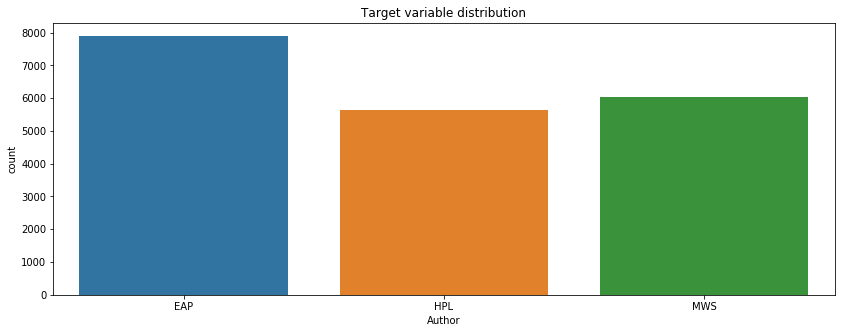

In [322]:
pyplot.figure(figsize=(14,5))
sns.countplot(authored_contents['author'],)
pyplot.xlabel('Author')
pyplot.title('Target variable distribution')
pyplot.show()

Now, grouping all the documents by each author to better understand the count.

In [228]:
authored_contents.groupby('author').size()

author
EAP    7900
HPL    5635
MWS    6044
dtype: int64

Below, we shall study the text length in the testing dataset.

In [229]:
# examine the same in test data

testing_records = len(unauthored_contents)

unauthored_contents['text_length'] = unauthored_contents['text'].str.len()

In [230]:
unauthored_contents.head()

,id,text,text_length
0,id02310,"Still, as I urged our leaving Ireland with suc...",110
1,id24541,"If a fire wanted fanning, it could readily be ...",330
2,id00134,And when they had broken down the frail door t...,189
3,id27757,While I was thinking how I should possibly man...,223
4,id04081,I am not sure to what limit his knowledge may ...,53


##### Distribution of semantics

Lets study the pattern of the documents.

In the code cell below, we shall grab few statistics to understand the writing patterns of the authors. We shall evaluate following parameters for each document:
- Number of words
- Number of unique words
- Number of characters
- Number of stopwords
- Number of punctuations
- Number of words in uppercase
- Number of words in titlecase
- Mean length of each word

This is to study the pattern of writing of each given author.

In [360]:
def text_len(df):
    df['num_words'] = df['text'].apply(lambda x: len(str(x).split()))
    df['num_uniq_words'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['num_chars'] = df['text'].apply(lambda x: len(str(x)))
    df['num_stopwords'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() 
                                                          if w in set(stopwords.words('english'))]))
    df['num_punctuations'] = df['text'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))
    df['num_words_upper'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df['num_words_title'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['mean_word_len'] = df['text'].apply(lambda x: numpy.mean([len(w) for w in str(x).split()]))

In [361]:
text_len(authored_contents)
text_len(unauthored_contents)

In [369]:
# authored_contents

In [233]:
def plot_heatmap(df):
    pyplot.figure(figsize=(14,6))

    pyplot.subplot(211)
    sns.heatmap(pandas.crosstab(df['author'], df['num_words']), cmap='gist_earth', xticklabels=True)
    pyplot.xlabel('Original text word count')
    pyplot.ylabel('Author')


    pyplot.subplot(212)
    sns.heatmap(pandas.crosstab(df['author'], df['num_uniq_words']), cmap='gist_heat', xticklabels=True)
    pyplot.xlabel('Unique text word count')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()


    pyplot.subplot(212)
    sns.heatmap(pandas.crosstab(df['author'], df['num_punctuations']), cmap='gist_heat', xticklabels=True)
    pyplot.xlabel('Punctuations')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()


    pyplot.subplot(212)
    sns.heatmap(pandas.crosstab(df['author'], df['mean_word_len']), cmap='gist_heat', xticklabels=False)
    pyplot.xlabel('Mean word length')
    pyplot.ylabel('Author')
    pyplot.tight_layout()
    pyplot.show()

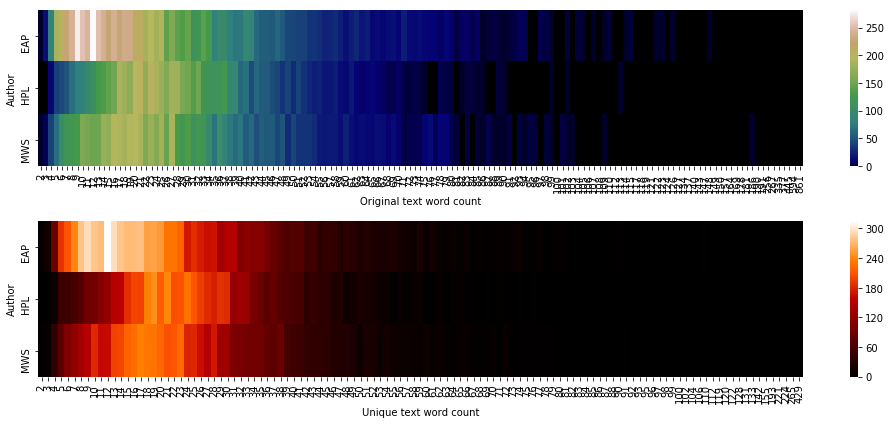

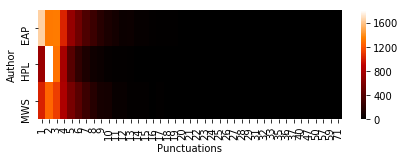

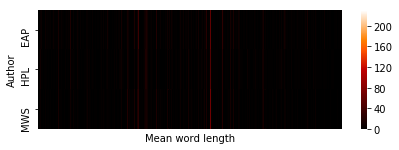

In [234]:
plot_heatmap(authored_contents)

So, far this heatmap explains what words were frequently used across the documents for each author.

We need more insights what words do they pick to better explain their interests of literature.

##### Wordcloud

In [287]:
eap_documents = authored_contents[authored_contents.author == 'EAP']['text'].values
hpl_documents = authored_contents[authored_contents.author == 'HPL']['text'].values
mws_documents = authored_contents[authored_contents.author == 'MWS']['text'].values

In [324]:
eap_words = " ".join(eap_documents)
hpl_words = " ".join(hpl_documents)
mws_words = " ".join(mws_documents)

In [325]:
from wordcloud import WordCloud, STOPWORDS

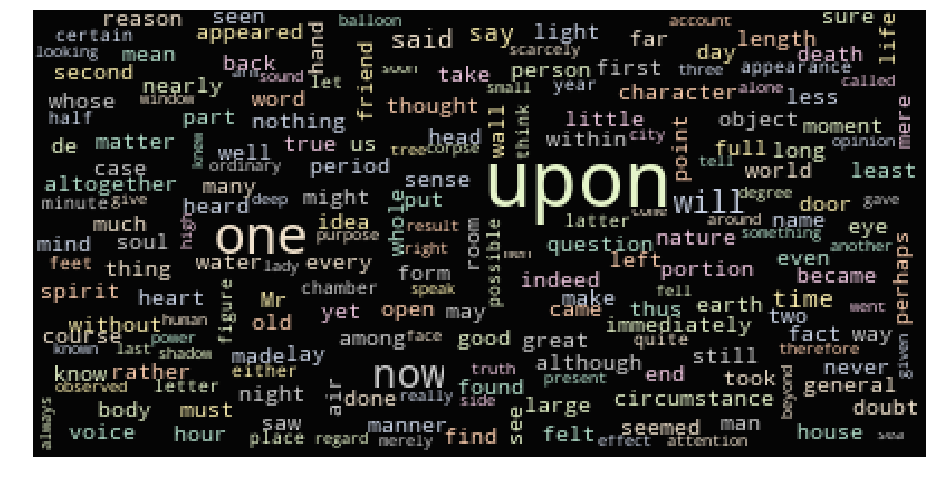

In [337]:
pyplot.figure(figsize=(16,13))

wordcloud = WordCloud(relative_scaling = 1.0, stopwords = STOPWORDS, max_font_size= 35)
wordcloud.generate(eap_words)
pyplot.imshow(wordcloud.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
pyplot.axis('off')
pyplot.show()

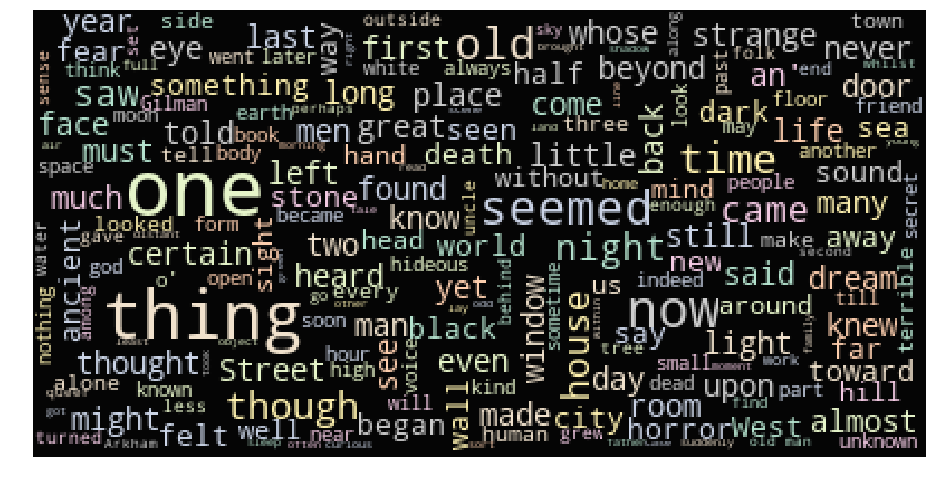

In [338]:
pyplot.figure(figsize=(16,13))

wordcloud = WordCloud(relative_scaling = 1.0, stopwords = STOPWORDS, max_font_size= 35)
wordcloud.generate(hpl_words)
pyplot.imshow(wordcloud.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
pyplot.axis('off')
pyplot.show()

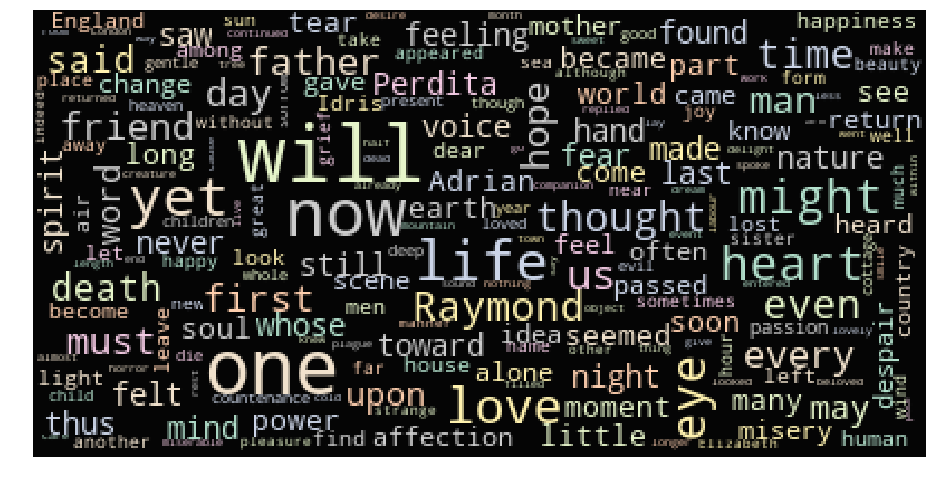

In [339]:
pyplot.figure(figsize=(16,13))

wordcloud = WordCloud(relative_scaling = 1.0, stopwords = STOPWORDS, max_font_size= 35)
wordcloud.generate(mws_words)
pyplot.imshow(wordcloud.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
pyplot.axis('off')
pyplot.show()

These wordclouds does now explains more about authors and their preferences towards their writings.

As __Edgar Allan Poe__ was particularly known for tales of mystery and the macabre. So, words like _death, soul, life, corpse, spirit and shadow_ better describes his interests.

As __Howard Phillips Lovecraft__ was famous for the work of horror fiction. So, words like _fear, horror and body_ describes his interests.

As __Mary Wollstonecraft Shelley__ was a novelist, short story writer, dramatist, essayist, biographer, and travel writer. So, _words, love, affection, happiness, misery, despair, beauty and pleasure_ best describes her interests.

Since, these 2 authors completely shares their own areas of interests and being mutually exclusive, we can better understand the dataset now.

We can later verify the the unpredicted dataset once they are predicted.

### Data Preprocessing

Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called categorical variables) be converted. 

As with the non-numeric features, we need to convert the non-numeric target label, `author` to numerical values for the learning algorithm to work. Since there are only three possible categories for this label (`EAP`, `HPL` and `MWS`), we can avoid using one-hot encoding and simply encode these two categories as 0, 1 and 2 respectively.

In code cell below, you will need to implement the following:

- Convert the target label 'income_raw' to numerical entries. Set records with "EAP" to 0, records with "HPL" to 1 and records with "MWS" to 2 and storing it in `numerical_author` column.
- Downcase, stem and remove punctations from the `text` ad storing it in `scrubbed_text` column.

##### Binarizing target variable

In [366]:
authored_contents['numerical_author'] = authored_contents.author.map({ 'EAP': 0, 'HPL': 1, 'MWS': 2 })

In [368]:
# Quick view of preprocessing

authored_contents[['text', 'author', 'numerical_author']].head()

,text,author,numerical_author
0,"This process, however, afforded me no means of...",EAP,0
1,It never once occurred to me that the fumbling...,HPL,1
2,"In his left hand was a gold snuff box, from wh...",EAP,0
3,How lovely is spring As we looked from Windsor...,MWS,2
4,"Finding nothing else, not even gold, the Super...",HPL,1


In [236]:
authored_contents.head()

,id,text,author,text_length,num_words,num_uniq_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,numerical_author
0,id26305,"This process, however, afforded me no means of...",EAP,231,41,35,231,19,7,2,3,4.658537,0
1,id17569,It never once occurred to me that the fumbling...,HPL,71,14,14,71,8,1,0,1,4.142857,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,36,32,200,16,5,0,1,4.583333,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,34,32,206,13,4,0,4,5.088235,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,27,25,174,11,4,0,2,5.481481,1


We will now clean texts by tokenizing, removing punctuations and stemming. This will reduce the feature set.

##### Scrubbing of data

In [237]:
all_stopwords = stopwords.words('english')
ps = PorterStemmer()

def scrub_text(data_frame):
    sentences = []
    for i in data_frame.values:
        sentence = unicode(i[1], 'utf-8')

        # remove all punctuations
        sentence = sentence.translate(string.punctuation)

        # break sentence into words
        array_of_words = word_tokenize(sentence)

        # removes all English stopwords
        array_of_words = [word for word in array_of_words if word.lower() not in all_stopwords]

        # singularise words in the array_of_words
        array_of_words = [ps.stem(word) for word in array_of_words]
        cleaned_sentence = ' '.join(array_of_words)

        sentences.append(cleaned_sentence)

    return sentences

In [238]:
# Run the #scrub_text over the text in the training and testing datasets.

training_cleaned_texts = scrub_text(authored_contents)
testing_cleaned_texts = scrub_text(unauthored_contents)

Saving the cleaned text into `scrubbed_text` for both `authored_contents` and `unauthored_contents`.

However, we will not use this since this will defeat the purpose to analyse the semantics of texts already authored.

Soon, we shall see what is the performance of classifiers on both set of data i.e. `scrubbed_text` and `text`.

In [239]:
authored_contents['scrubbed_text'] = training_cleaned_texts

unauthored_contents['scrubbed_text'] = testing_cleaned_texts

In [240]:
# Define labels and features set

X = authored_contents['text']
Y = authored_contents['numerical_author']

### Shuffle and split data

We will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [357]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [358]:
# Show the results of the split

# Features
print("Training set has " + str(X_train.shape[0]) + " features.")
print("Testing set has " + str(X_test.shape[0]) + " features.")

# Labels
print("Training set has " + str(Y_train.shape[0]) + " labels.")
print("Testing set has " + str(Y_test.shape[0]) + " labels.")

print("\nPrinting labels set...")
print(Y_train.value_counts())

print(Y_test.value_counts())

Training set has 15663 features.
Testing set has 3916 features.
Training set has 15663 labels.
Testing set has 3916 labels.

Printing labels set...
0    6300
2    4830
1    4533
Name: numerical_author, dtype: int64
0    1600
2    1214
1    1102
Name: numerical_author, dtype: int64


###### Another cross validation:

We will now cross-validate our training set using `sklearn.model_selection.StratifiedShuffleSplit` approach

This as mentioned in the training videos, this will divide our training set into N folds.
We will iterate over each fold acting as testing data at a single point of time and rest of them will act as training sets.

We will tweak certain parameters to learn the dataset pattern.

In [243]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X,
                                                        Y,
                                                        stratify = Y,
                                                        test_size = 0.2,
                                                        random_state = 42)

In [244]:
# Show the results of the split

# Features
print("Training set has " + str(X2_train.shape[0]) + " features.")
print("Testing set has " + str(X2_test.shape[0]) + " features.")

# Labels
print("\nTraining set has " + str(Y2_train.shape[0]) + " labels.")
print("Testing set has " + str(Y2_test.shape[0]) + " labels.")

print("\nPrinting labels set...")
print(Y_train.value_counts())

print(Y_test.value_counts())

Training set has 15663 features.
Testing set has 3916 features.

Training set has 15663 labels.
Testing set has 3916 labels.

Printing labels set...
0    6300
2    4830
1    4533
Name: numerical_author, dtype: int64
0    1600
2    1214
1    1102
Name: numerical_author, dtype: int64


### Word vectors

We shall now grab the words in a document and tokenize them and build vocabulary out of them.

We are still working on the original texts that contains punctuations and un-stemmed words.

In [245]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X2_train)

training_vectorizer = vectorizer.transform(X2_train)

In [376]:
# Quick view of vectors from the texts

training_vectorizer.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [340]:
print(len(vectorizer.get_feature_names()))

22922


In [341]:
# run vectorizer for X2_test

testing_vectorizer = vectorizer.transform(X2_test)

As per the above transformation, `training_vectorizer` is our feature set.

### Evaluating model performance

The following are some of the supervised learning models that will be used to evaluate the performance of the model on this problem and the dataset.

- Multinomial Naive Bayes
- Logistic Regression
- XGBoost from the ensemble methods
- SVM
- Stochastic Gradient Descent Classifier (SGDC)

In [246]:
# Include libraries to evaluate performances on the attached dataset

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

##### Multinomial Naive Bayes

In [129]:
from sklearn.naive_bayes import MultinomialNB

kfold = KFold(n_splits = 10, random_state = 7)

model = MultinomialNB()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

Mean value: 0.836365907311
Training time: 0.141657114029


##### Logistic Regression

In [130]:
from sklearn.linear_model import LogisticRegression

kfold = KFold(n_splits = 10, random_state = 7)

model = LogisticRegression()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

Mean value: 0.821044067415
Training time: 9.78910684586


##### SVM

In [131]:
from sklearn.svm import SVC

kfold = KFold(n_splits = 10, random_state = 7)

model = SVC()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

Mean value: 0.403944950165
Training time: 528.707161903


##### Stochastic Gradient Descent Classifier

In [132]:
from sklearn.linear_model import SGDClassifier

kfold = KFold(n_splits = 10, random_state = 7)

model = SGDClassifier()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

/Users/kavitakanojiya/anaconda2/envs/udacity/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Mean value: 0.799336327724
Training time: 0.432309865952


##### XGBoost

In [133]:
from xgboost import XGBClassifier

model = XGBClassifier()
start = time()
results = cross_val_score(model, training_vectorizer, Y2_train, cv=kfold)
end = time()

print("Mean value: {}").format(results.mean())
print("Training time: {}").format(end - start)

Mean value: 0.635254869552
Training time: 84.1037828922


#### Statistics:

         Algorithm            Mean accuracy    Training time            O/P
    Multinomial Naive Bayes      0.836            0.141        .83 accuracy with the least amount of training time
     Logistic Regression         0.821            9.789        .82 accuracy with some amount of training time
            SGDC                 0.799            0.432        .79 accuracy with the least of training time
          XGBoost                0.635            84.103       .63 accuracy with unacceptable training time
            SVM                  0.403            528.707      least accuracy with highest amount of training time

#### Classifier performances over scrubbed_text and text

Now, lets see the performance of the classifiers when texts are cleaned with punctuations, lowercased and properly stemmed.

This is what I have done in first place.

         Algorithm            Mean accuracy    Training time            O/P
    Multinomial Naive Bayes      0.823            0.093        .82 accuracy with the least amount of training time
     Logistic Regression         0.805            2.654        .80 accuracy with some amount of training time
            SGDC                 0.794            0.322        .79 accuracy with the least of training time
          XGBoost                0.612            52.510       .61 accuracy with unacceptable training time
            SVM                  0.403            299.708      least accuracy with highest amount of training time

##### Model performance conclusion

Comparing both of the statistics, we see improvement in the accuracy of Multinomial Naive Bayes when raw features are iterated i.e. without cleaning up the texts.

We shall proceed with the Multinomial Naive Bayes classifier.

### Parameter tuning

Fine tune the chosen model. Use grid search (GridSearchCV) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this.

In the code cell below, we shall implement the following:

- Import sklearn.grid_search.GridSearchCV and sklearn.metrics.make_scorer.
- Initialize the classifier you've chosen and store it in `model`.
- Create a dictionary of parameters you wish to tune for the chosen model.
  Example: parameters = {'parameter' : [list of values]}.
- Use make_scorer to create an fbeta_score scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier clf using the 'scorer', and store it in grid_obj.
- Fit the grid search object to the training data (`training_vectorizer, Y2_train`), and store it in grid_fit.

In [251]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.naive_bayes import MultinomialNB

In [252]:
model = MultinomialNB()

parameters = { 'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0] }

scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(model, parameters)

grid_fit = grid_obj.fit(training_vectorizer, Y2_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

grid_fit.best_params_

{'alpha': 0.5}

### Model training

##### Fit and predict the data

In [253]:
mnb = MultinomialNB(alpha = 0.5)

In [254]:
mnb.fit(training_vectorizer, Y2_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [350]:
mnb.predict_proba(training_vectorizer)

array([[  5.16034854e-04,   9.97155622e-01,   2.32834270e-03],
       [  3.43333728e-05,   4.15770588e-04,   9.99549896e-01],
       [  1.55571525e-03,   9.97626448e-01,   8.17836696e-04],
       ..., 
       [  1.09712723e-03,   2.31633583e-05,   9.98879709e-01],
       [  2.31793463e-07,   1.01182522e-11,   9.99999768e-01],
       [  5.39063326e-04,   1.27815668e-03,   9.98182780e-01]])

In [351]:
mnb.feature_log_prob_

array([[-11.60343018, -11.09260455, -12.70204247, ..., -11.60343018,
        -12.70204247, -12.70204247],
       [-12.47882127, -12.47882127, -12.47882127, ..., -12.47882127,
        -10.86938335, -11.38020898],
       [-12.5333816 , -12.5333816 , -11.43476931, ..., -12.5333816 ,
        -12.5333816 , -12.5333816 ]])

In [255]:
Y_train_prediction = mnb.predict(training_vectorizer)

In [256]:
Y_test_prediction = mnb.predict(testing_vectorizer)

##### Accuracy score

In [257]:
# calculate score for predicted data against testing data
from sklearn import metrics

# compare predicted resultset with the test set
metrics.accuracy_score(Y2_test, Y_test_prediction)

0.84320735444330952

In [258]:
# calculate score for predicted data against training data

metrics.accuracy_score(Y2_train, Y_train_prediction)

0.92083253527421316

In [259]:
# Calculate confusion matrix

metrics.confusion_matrix(Y2_test, Y_test_prediction)

array([[1316,   91,  173],
       [ 105,  940,   82],
       [ 107,   56, 1046]])

In [260]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = mnb.predict_proba(testing_vectorizer)
y_pred_prob[:10]

array([[  9.93709572e-01,   6.29042477e-03,   2.87355497e-09],
       [  5.68562145e-01,   2.06310121e-01,   2.25127734e-01],
       [  6.71151485e-02,   9.26647178e-01,   6.23767385e-03],
       [  9.99838325e-01,   1.41584582e-04,   2.00903042e-05],
       [  5.69150560e-01,   3.10660069e-03,   4.27742839e-01],
       [  6.49443927e-08,   2.33385453e-07,   9.99999702e-01],
       [  2.63405896e-06,   9.83462607e-01,   1.65347593e-02],
       [  3.16817134e-09,   1.92622091e-17,   9.99999997e-01],
       [  2.32889616e-05,   9.99486010e-01,   4.90701076e-04],
       [  3.38207837e-02,   9.57331074e-01,   8.84814260e-03]])

##### Classification report

In [261]:
print(classification_report(Y2_train, Y_train_prediction, target_names=['EAP', 'HPL', 'MWS']))

             precision    recall  f1-score   support

        EAP       0.94      0.90      0.92      6320
        HPL       0.93      0.92      0.93      4508
        MWS       0.89      0.94      0.92      4835

avg / total       0.92      0.92      0.92     15663



##### ROC and AUC curves

In [262]:
fpr, tpr, thresholds = metrics.roc_curve(Y2_train, Y_train_prediction, pos_label = 1)

print("Multinomial naive bayes AUC: {0}").format(metrics.auc(fpr, tpr))

Multinomial naive bayes AUC: 0.535368399304


Precision, Recall and F1 score is reported.

AUC metric reported to be 0.535

### Predict unexplored data

##### Predict

In [263]:
# vectorise the unauthored_contents

unpredicted_texts = unauthored_contents['text']

unpredicted_texts_vectorizer = vectorizer.transform(unpredicted_texts)

In [264]:
unpredicted_texts_vectorizer

<8392x22922 sparse matrix of type '<type 'numpy.int64'>'
	with 178310 stored elements in Compressed Sparse Row format>

In [265]:
unpredicted_texts_prediction = mnb.predict(unpredicted_texts_vectorizer)

In [266]:
# calculate predicted probabilities for X_test_dtm
predicted_prob = mnb.predict_proba(unpredicted_texts_vectorizer)
predicted_prob[:10]

array([[  3.84695760e-04,   7.20862383e-05,   9.99543218e-01],
       [  9.99993268e-01,   6.72549843e-06,   6.50585274e-09],
       [  1.51954970e-03,   9.98480418e-01,   3.24087158e-08],
       [  5.34223455e-01,   4.65776527e-01,   1.76516762e-08],
       [  9.56425379e-01,   7.68172935e-03,   3.58928916e-02],
       [  9.92226248e-01,   7.77039446e-03,   3.35708094e-06],
       [  9.81047293e-01,   1.40793728e-02,   4.87333392e-03],
       [  5.41913842e-04,   3.22238929e-03,   9.96235697e-01],
       [  9.99875549e-01,   1.24449463e-04,   1.84810936e-09],
       [  9.39983277e-01,   9.85227174e-03,   5.01644515e-02]])

In [267]:
unpredicted_texts_prediction

array([2, 0, 1, ..., 0, 2, 1])

In [268]:
len(unauthored_contents)

8392

In [269]:
numerical_authors = pandas.DataFrame(unpredicted_texts_prediction, columns=['num_author'])

predicted_unauthored_contents = pandas.concat([unauthored_contents, numerical_authors], axis=1)

##### Reflect author names

In [270]:
predicted_unauthored_contents['author'] = predicted_unauthored_contents.num_author.map({ 0: 'EAP', 1: 'HPL', 2: 'MWS' })

In [271]:
predicted_unauthored_contents.groupby('author').size()

author
EAP    3264
HPL    2306
MWS    2822
dtype: int64

In [272]:
predicted_unauthored_contents.head()

,id,text,text_length,num_words,num_uniq_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,scrubbed_text,num_author,author
0,id02310,"Still, as I urged our leaving Ireland with suc...",110,19,19,110,9,3,1,3,4.842105,"still , urg leav ireland inquietud impati , fa...",2,MWS
1,id24541,"If a fire wanted fanning, it could readily be ...",330,62,49,330,33,7,1,3,4.338710,"fire want fan , could readili fan newspap , go...",0,EAP
2,id00134,And when they had broken down the frail door t...,189,33,30,189,15,3,0,1,4.757576,broken frail door found : two cleanli pick hum...,1,HPL
3,id27757,While I was thinking how I should possibly man...,223,41,34,223,19,5,2,3,4.463415,"think possibl manag without , one actual tumbl...",0,EAP
4,id04081,I am not sure to what limit his knowledge may ...,53,11,11,53,6,1,1,1,3.909091,sure limit knowledg may extend .,0,EAP


### Conclusion

##### Compare heatmaps from the prediction

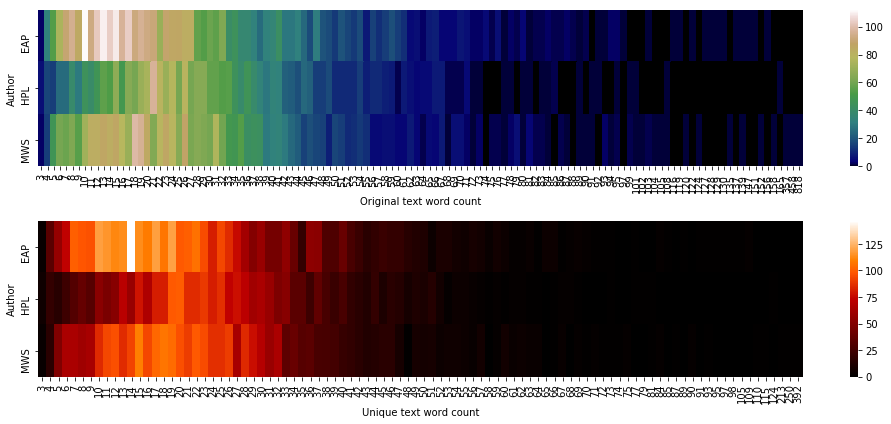

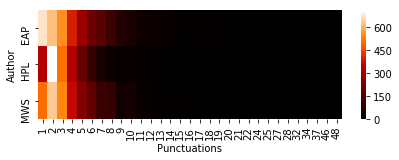

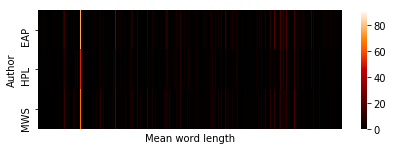

In [273]:
# Plotting over the test.csv that we ran the prediction above to study the analysis.
plot_heatmap(predicted_unauthored_contents)

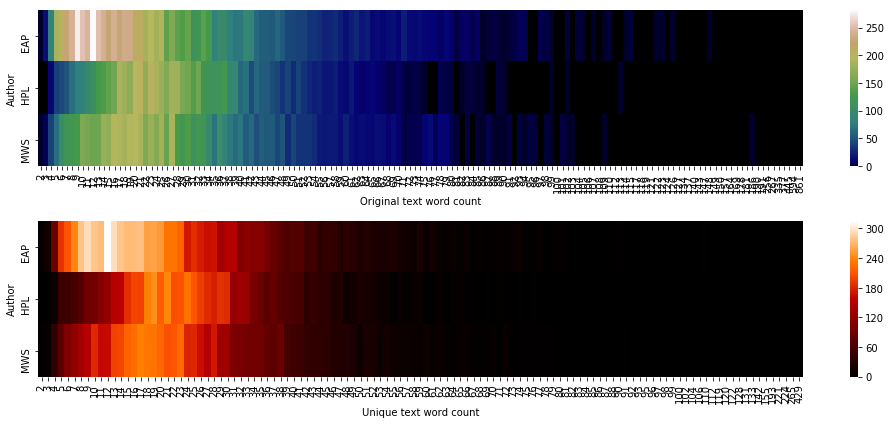

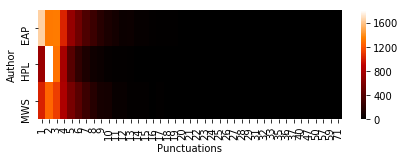

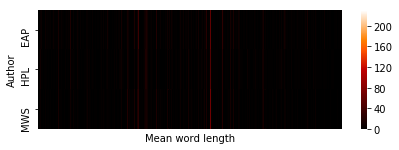

In [274]:
# Comparing the heatmap that we plotted above using `authored_contents`

plot_heatmap(authored_contents)

Considering parameters:

1. Punctuations: Both of them represent identical plots for both of the datasets.
   
2. Unique words used: Both of them utilised and represented identically.

##### Compare Wordclouds from the prediction

In [345]:
predicted_eap_documents = predicted_unauthored_contents[predicted_unauthored_contents.author == 'EAP']['text'].values
predicted_hpl_documents = predicted_unauthored_contents[predicted_unauthored_contents.author == 'HPL']['text'].values
predicted_mws_documents = predicted_unauthored_contents[predicted_unauthored_contents.author == 'MWS']['text'].values

In [346]:
predicted_eap_words = " ".join(predicted_eap_documents)
predicted_hpl_words = " ".join(predicted_hpl_documents)
predicted_mws_words = " ".join(predicted_mws_documents)

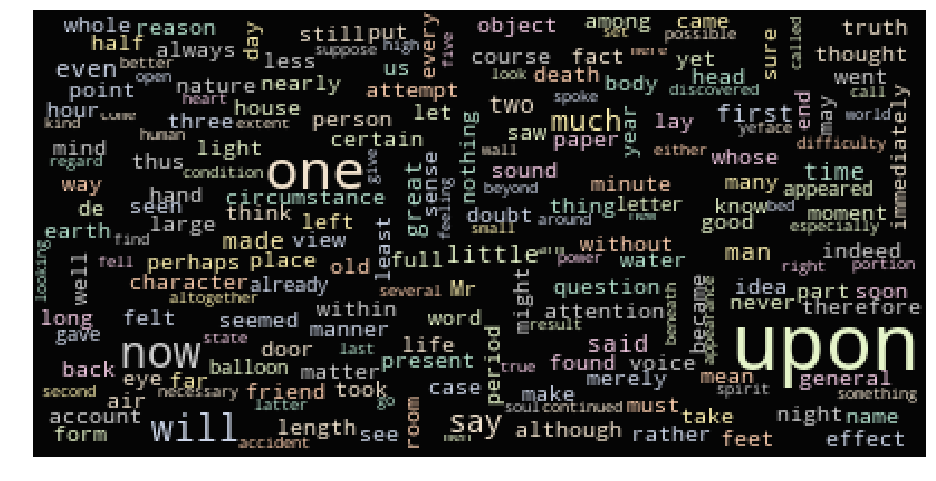

In [347]:
pyplot.figure(figsize=(16,13))

wordcloud = WordCloud(relative_scaling = 1.0, stopwords = STOPWORDS, max_font_size= 35)
wordcloud.generate(predicted_eap_words)
pyplot.imshow(wordcloud.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
pyplot.axis('off')
pyplot.show()

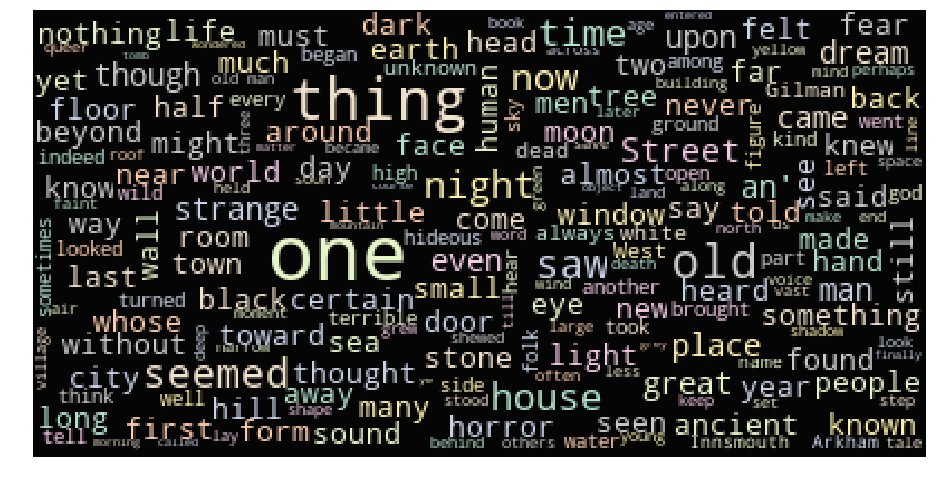

In [348]:
pyplot.figure(figsize=(16,13))

wordcloud = WordCloud(relative_scaling = 1.0, stopwords = STOPWORDS, max_font_size= 35)
wordcloud.generate(predicted_hpl_words)
pyplot.imshow(wordcloud.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
pyplot.axis('off')
pyplot.show()

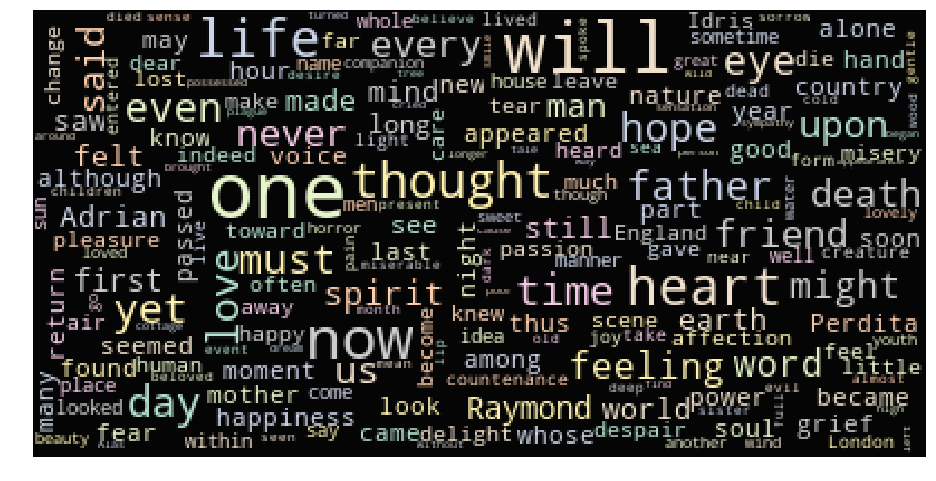

In [349]:
pyplot.figure(figsize=(16,13))

wordcloud = WordCloud(relative_scaling = 1.0, stopwords = STOPWORDS, max_font_size= 35)
wordcloud.generate(predicted_mws_words)
pyplot.imshow(wordcloud.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
pyplot.axis('off')
pyplot.show()